9.7 실제 우리나라 월별 콜금리와 물가상승률 자료를 이용해서 시변 통화정책 반응함수를 추정하시오

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from tqdm import tqdm

In [2]:
data=pd.read_csv("./data/korea_time_varying_data.csv", index_col=0, parse_dates=True)

In [3]:
y=data['call_ir'].iloc[1:]
x=data.shift(1).iloc[1:].dropna()

Sampling Functions

In [ ]:
def sample_omega(params:dict, beta:np.ndarray) -> np.ndarray:
    # variance
    omega_shape = params['omega_shape']
    omega_scale = params['omega_scale']
    omega_multiple = params['omega_multiple']

    res=beta[1:]-beta[:-1]

    a=(omega_shape+len(res))/2
    b=(omega_scale+sum(res**2)*omega_multiple)/2

    # Sample from inverse gamma distribution
    omega = stats.invgamma.rvs(a, scale=b)/omega_multiple
    return omega


def sample_c_and_phi(y:pd.Series, x:pd.DataFrame, params:dict, beta:np.ndarray, sigma2:float)->tuple:
    c_phi_mean=params['c_phi_mean']
    c_phi_cov=params['c_phi_cov']

    res=y-x['korea_cpi_yoy'].dot(beta) # [T, ]
    z=np.vstack([np.ones(len(x)), x['call_ir']]).T # [T,2]

    inv_c_phi_cov = np.linalg.inv(c_phi_cov)
    c_phi_cov_post = np.linalg.inv(inv_c_phi_cov + z.T.dot(z)/sigma2) # [2,2]
    c_phi_cov_post= (c_phi_cov_post + c_phi_cov_post.T) / 2  # to avoid numerical issue
    c_phi_mean_post= c_phi_cov_post @ (inv_c_phi_cov @ c_phi_mean + z.T.dot(res)/sigma2) # [2,]

    c_phi_sample=stats.multivariate_normal.rvs(mean=c_phi_mean_post, cov=c_phi_cov_post)
    if abs(c_phi_sample[1])>=1: # to ensure stationarity
        return None
    return c_phi_sample


def sample_sigma2(y:pd.Series, x:pd.DataFrame, params:dict, c_phi:np.ndarray, beta:np.ndarray, sigma2:float)->float:
    sigma2_shape=params['sigma2_shape']
    sigma2_scale=params['sigma2_scale']
    sigma2_multiple=params['sigma2_multiple']

    res=y-x['korea_cpi_yoy'].dot(beta)-c_phi[0]-c_phi[1]*x['call_ir']
    n=len(res)

    a=(sigma2_shape+n)/2
    b=(sigma2_scale+sum(res**2)*sigma2_multiple)/2

    sigma2=stats.invgamma.rvs(a, scale=b)/sigma2_multiple
    return sigma2


def sample_beta(y:pd.Series, x:pd.DataFrame, params:dict, c_phi:np.ndarray, beta:np.ndarray, sigma2:float, omega:float)->np.ndarray:
    T=y.shape[0]
    k=beta.shape[1]
    y_adj=y-c_phi[0]-c_phi[1]*x['call_ir'] # latent variable adjustment
    # Forward Filtering Backward Sampling (FFBS) Algorithm

    # 1. Forward Kalman Filter
    beta_t=np.zeros((T, k)) 
    beta_t_cov=np.zeros((T, k, k))
    beta_prior=np.zeros(k)
    beta_prior_cov=np.eye(k)

    for t in range(T):
        # Prediction Step
        h_t=x[['korea_cpi_yoy']].iloc[t].values.reshape(-1, 1) # [k,1]
        beta_pred=beta_prior
        beta_pred_cov=beta_prior_cov+np.eye(k)*omega
        beta_pred_cov= (beta_pred_cov + beta_pred_cov.T) / 2  # to avoid numerical issue
        kalman_gain=beta_pred_cov @ h_t.T @ np.linalg.inv(h_t @ beta_pred_cov @ h_t.T + sigma2)

        # Update Step
        beta_t[t, :]=beta_pred + kalman_gain.flatten() * (y_adj.iloc[t] - (h_t.T @ beta_pred).item())
        beta_t_cov[t, :, :]=(np.eye(k) - kalman_gain @ h_t) @ beta_pred_cov

        # Set up for next iteration
        beta_prior=beta_t[t, :]
        beta_prior_cov=beta_t_cov[t, :, :]

    # 2. Backward Sampling
    beta_sample=np.zeros((T, k))
    beta_sample[-1, :]=stats.multivariate_normal.rvs(mean=beta_t[-1, :], cov=beta_t_cov[-1, :, :])

    for t in range(T-2, -1, -1):
        beta_pred=beta_t[t, :] # t+1 | t
        beta_pred_cov=beta_t_cov[t, :, :]+np.eye(k)*omega # t+1 | t
        beta_pred_cov= (beta_pred_cov + beta_pred_cov.T) / 2  # to avoid numerical issue

        beta_mean=beta_t[t, :] + beta_t_cov[t, :, :] @ np.linalg.inv(beta_pred_cov) @ (beta_sample[t+1, :] - beta_pred)
        beta_cov=beta_t_cov[t, :, :] - beta_t_cov[t, :, :] @ np.linalg.inv(beta_pred_cov) @ beta_t_cov[t, :, :]
        beta_cov= (beta_cov + beta_cov.T) / 2  # to avoid numerical issue

        beta_sample[t, :]=stats.multivariate_normal.rvs(mean=beta_mean, cov=beta_cov)
    return beta_sample


Main Functions

In [5]:
# set prior hyperparameters

# c, phi
c_phi_mean=np.array([0.05, 0.8])
c_phi_cov=np.eye(2)*0.01
c_phi=c_phi_mean.copy()

# sigma2 for y
sigma2_shape=10.0
sigma2_scale=10.0
sigma2_multiple=100
sigma2=sigma2_scale*0.5/(sigma2_shape*0.5-1) # initial value by prior mean

# beta mean prior
results=sm.OLS(y, sm.add_constant(x)).fit()
beta=np.expand_dims(np.ones(len(y))*results.params['korea_cpi_yoy'], axis=1) # initial value by OLS

# omega(var) for beta
omega_shape=10.0
omega_scale=10.0
omega_multiple=100

# burn-in and iterations
burn_in=500
n_samples=500

# hyperparameter dictionary
parameter_dict={
    'c_phi_mean':c_phi_mean,
    'c_phi_cov':c_phi_cov,
    'sigma2_shape':sigma2_shape,
    'sigma2_scale':sigma2_scale,
    'sigma2_multiple':sigma2_multiple,
    'omega_shape':omega_shape,
    'omega_scale':omega_scale,
    'omega_multiple':omega_multiple,
}

# store MCMC results
beta_store=np.zeros((n_samples, len(y)))
c_phi_non_cnt=0

for i in tqdm(range(burn_in+n_samples)):
    omega=sample_omega(parameter_dict, beta=beta)
    c_phi_cand=sample_c_and_phi(y, x, parameter_dict, beta=beta, sigma2=sigma2)
    if c_phi_cand is not None:
        c_phi=c_phi_cand
    else:
        c_phi_non_cnt+=1
    sigma2=sample_sigma2(y, x, parameter_dict, c_phi=c_phi, beta=beta, sigma2=sigma2)    
    beta=sample_beta(y, x, parameter_dict, c_phi=c_phi, beta=beta, sigma2=sigma2, omega=omega)
    if i>=burn_in:
        beta_store[i-burn_in, :]=beta[:, 0]
    




100%|██████████| 1000/1000 [01:01<00:00, 16.23it/s]


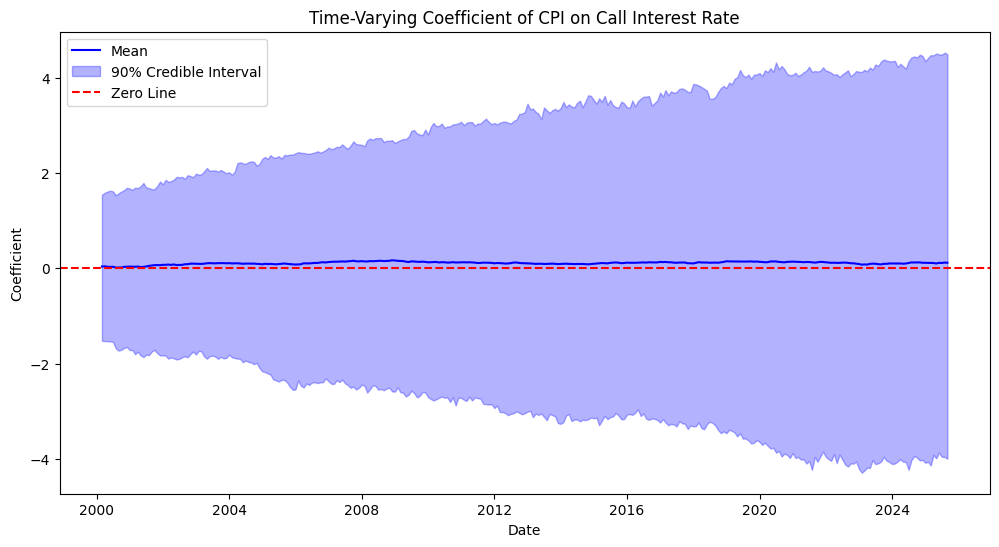

In [6]:
plt.figure(figsize=(12, 6))
beta_q95=np.percentile(beta_store, 95, axis=0)
beta_mean=beta_store.mean(axis=0)
beta_q05=np.percentile(beta_store, 5, axis=0)
plt.plot(y.index, beta_mean, label='Mean', color='blue')
plt.fill_between(y.index, beta_q05, beta_q95, color='blue', alpha=0.3, label='90% Credible Interval')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title('Time-Varying Coefficient of CPI on Call Interest Rate')
plt.xlabel('Date')
plt.ylabel('Coefficient')
plt.legend()